## Imports

In [193]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, AutoModelForCausalLM , AutoTokenizer, pipeline, RobertaTokenizer, RobertaForMaskedLM, AlbertTokenizer, AlbertModel, AlbertForMaskedLM
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from tqdm import tqdm
import unidecode
from time import sleep
import json
import json
import statistics 
logging.basicConfig(level=logging.INFO)# OPTIONAL
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D

## MAC Settings

In [194]:
print(f"PyTorch version: {torch.__version__}")
# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 1.13.1
Using device: mps


## Definitions

In [195]:
#TEMPLATES
EVALUATION_PATH = '../data/evaluation/'
RESULTS_PATH = '../data/results/'
ALBERT_BASE_TEMPLATE_1 = 'ALBERTbase[1]'
ALBERT_BASE_TEMPLATE_5 = 'ALBERTbase[5]'
ALBERT_LARGE_TEMPLATE_1 = 'ALBERTlarge[1]'
ALBERT_LARGE_TEMPLATE_5 = 'ALBERTlarge[1]'
BERT_BASE_TEMPLATE_1 = 'BERTbase[1]'
BERT_BASE_TEMPLATE_5 = 'BERTbase[5]'
BERT_LARGE_TEMPLATE_1 = 'BERTlarge[1]'
BERT_LARGE_TEMPLATE_5 = 'BERTlarge[5]'
ROBERTA_BASE_TEMPLATE_1 = 'RoBERTabase[1]'
ROBERTA_BASE_TEMPLATE_5 = 'RoBERTabase[5]'
ROBERTA_LARGE_TEMPLATE_1 = 'RoBERTalarge[1]'
ROBERTA_LARGE_TEMPLATE_5 = 'RoBERTalarge[5]'
BERTWEET_BASE_TEMPLATE_1 = 'BERTweetbase[1]'
BERTWEET_BASE_TEMPLATE_5 = 'BERTweetbase[5]'
BERTWEET_LARGE_TEMPLATE_1 = 'BERTweetlarge[1]'
BERTWEET_LARGE_TEMPLATE_5 = 'BERTweetlarge[5]'

MODELS =[ALBERT_BASE_TEMPLATE_1, ALBERT_BASE_TEMPLATE_5, ALBERT_LARGE_TEMPLATE_1, ALBERT_LARGE_TEMPLATE_5, 
         BERT_BASE_TEMPLATE_1, BERT_BASE_TEMPLATE_5, BERT_LARGE_TEMPLATE_1, BERT_LARGE_TEMPLATE_5,
         ROBERTA_BASE_TEMPLATE_1, ROBERTA_BASE_TEMPLATE_5, ROBERTA_LARGE_TEMPLATE_1, ROBERTA_LARGE_TEMPLATE_5,
         BERTWEET_BASE_TEMPLATE_1, BERTWEET_BASE_TEMPLATE_5, BERTWEET_LARGE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_5]

MODELS_NAMES = ['ALBERTbase[1]','ALBERTbase[5]','ALBERTlarge[1]','ALBERTlarge[5]',
                'BERTbase[1]','BERTbase[5]','BERTlarge[1]','BERTlarge[5]', 
                'RoBERTabase[1]','RoBERTabase[5]','RoBERTalarge[1]','RoBERTalarge[5]',
                'BERTweetbase[1]','BERTweetbase[5]','BERTweetlarge[1]','BERTweetlarge[5]']

NEO_ROW = 0
NEUTRAL_ROW = 1
BINARY_ROW = 2

#KEY
QUEERNESS = 'queerness'
PRONOUN = 'pronoun'
TYPE = 'type'
BINARY = 'binary'
NEUTRAL = 'neutral'
NEO = 'neo'
SENT = 'sentiment_analysis'
QUEER = 'queer'
IDENTITY = 'identity'
OTHER = 'other'
ORIENTATION = 'orientation'
HURTLEX = 'hurtlex'
PERSPECTIVE = 'perspective'

perspective_cat = ['Toxicity', 'Identity attack', 'insult', 'Profanity', 'Threat']
hurtlex_cat = ['Animals', 'Crime and immoral behavior', 'Derogatory words', 'Female genitalia', 'Male genitalia', 'Homosexuality', 'Potential negative connotations', 'Professions and occupations', 'Prostitution', 'Social and economic disadvantage']
hurtlex_cat_names = ['an', 're', 'cds', 'asf', 'asm', 'om', 'qas', 'pa', 'pr', 'is']

### Utils

In [196]:
# def get_model_name(model):
#     if model == ALBERT_BASE_TEMPLATE_1:
#         return 'ALBERT base [1]'
#     elif model == ALBERT_BASE_TEMPLATE_5:
#         return 'ALBERT base [5]'
#     elif model == ALBERT_LARGE_TEMPLATE_1:
#         return 'ALBERT large [1]'
#     elif model == ALBERT_LARGE_TEMPLATE_5:
#         return 'ALBERT large [5]'
#     elif model == BERT_BASE_TEMPLATE_1:
#         return 'BERT base [1]'
#     elif model == BERT_BASE_TEMPLATE_5:
#         return 'BERT base [5]'
#     elif model == BERT_LARGE_TEMPLATE_1:
#         return 'BERT large [1]'
#     elif model == BERT_LARGE_TEMPLATE_5:
#         return 'BERT base [5]'
#     elif model == ROBERTA_BASE_TEMPLATE_1:
#         return 'RoBERTa base [1]'
#     elif model == ROBERTA_BASE_TEMPLATE_5:
#         return 'RoBERTa base [5]'
#     elif model == ROBERTA_LARGE_TEMPLATE_1:
#         return 'RoBERTa large [1]'
#     elif model == ROBERTA_LARGE_TEMPLATE_5:
#         return 'RoBERTa large [5]'
#     elif model == BERTWEET_BASE_TEMPLATE_1:
#         return 'BERTweet base [1]'
#     elif model == BERTWEET_BASE_TEMPLATE_5:
#         return 'BERTweet base [5]'
#     elif model == BERT_LARGE_TEMPLATE_1:
#         return 'BERTweet large [1]'
#     elif model == BERT_LARGE_TEMPLATE_5:
#         return 'BERTweet large [5]'

# Graph

In [197]:
def error_bar(models):
    x = []
    y1_neo, y2_neutral, y3_binary= [], [], []
    yerr1_neo, yerr2_neutral, yerr3_binary = [], [], []
    for m in models:
        csv = pd.read_csv(RESULTS_PATH+m+'_afinn.csv', sep=";")
        x.append(m)
        y1_neo.append(csv.loc[NEO_ROW]['Score'])
        y2_neutral.append(csv.loc[NEUTRAL_ROW]['Score'])
        y3_binary.append(csv.loc[BINARY_ROW]['Score'])
        yerr1_neo.append(csv.loc[NEO_ROW]['StDev'])
        yerr2_neutral.append(csv.loc[NEUTRAL_ROW]['StDev'])
        yerr3_binary.append(csv.loc[BINARY_ROW]['StDev'])
    print(x)
    #x = list("ABC")
    #y1_neo, y2_neutral, y3_binary= [0.5, 1.2, 0.7], [0.7, 1.5, 2], [1.7, 0.5, 2]
    #yerr1_neo, yerr2_neutral, yerr3_binary = np.random.rand(3, len(x))*4+0.3
    # print(y1_neo)
    # print(y2_neutral)
    # print(y3_binary)
    fig, ax = plt.subplots()
    plt.xticks(rotation=45)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
    trans1 = Affine2D().translate(0.0, 0.0) + ax.transData
    trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
    trans3 = Affine2D().translate(+0.2, 0.0) + ax.transData
    er1 = ax.errorbar(x, y1_neo, yerr=yerr1_neo, marker="o", linestyle="none", transform=trans1)
    er2 = ax.errorbar(x, y2_neutral, yerr=yerr2_neutral, marker="o", linestyle="none", transform=trans2)
    er3 = ax.errorbar(x, y3_binary, yerr=yerr3_binary, marker="o", linestyle="none", transform=trans3)
    plt.figure(facecolor='white')
    plt.show()

['ALBERTbase[1]', 'ALBERTbase[5]', 'ALBERTlarge[1]', 'ALBERTlarge[5]', 'BERTbase[1]', 'BERTbase[5]', 'BERTlarge[1]', 'BERTlarge[5]', 'RoBERTabase[1]', 'RoBERTabase[5]', 'RoBERTalarge[1]', 'RoBERTalarge[5]', 'BERTweetbase[1]', 'BERTweetbase[5]', 'BERTweetlarge[1]', 'BERTweetlarge[5]']


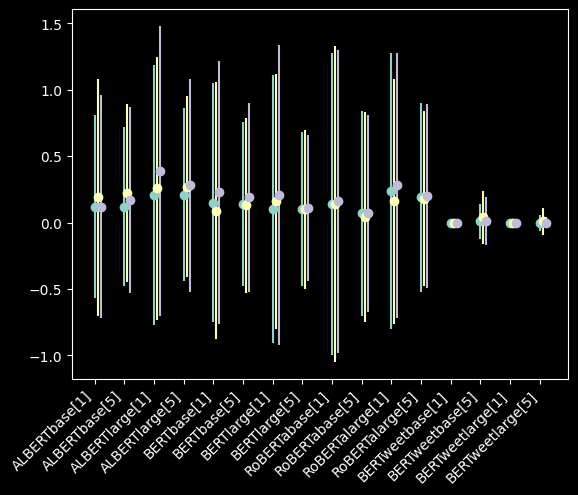

<Figure size 640x480 with 0 Axes>

In [198]:
error_bar(MODELS_NAMES)